In [ ]:
import cv2
import numpy as np
import os
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

emnist_mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

In [101]:
class CAPTCHAClassifier(nn.Module):
    def __init__(self, num_classes=62):
        super(CAPTCHAClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2, 2)

        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [102]:
def load_model(model_path='model.pth'):
    model = CAPTCHAClassifier()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def preprocess_character_image(image):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0)
    return image

In [103]:
def load_captcha_image(image_path):
    image = cv2.imread(image_path)
    return image


def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth_image = cv2.medianBlur(gray, 5)
    thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((4, 4), np.uint8)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    return thresh


def merge_contours(contours, min_distance=12):
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    merged_boxes = []

    for box in bounding_boxes:
        x, y, w, h = box
        merged = False
        for i, (mx, my, mw, mh) in enumerate(merged_boxes):
            if abs(x - mx) < min_distance or abs((x + w) - (mx + mw)) < min_distance:
                merged_boxes[i] = (
                    min(x, mx), min(y, my), max(x + w, mx + mw) - min(x, mx), max(y + h, my + mh) - min(y, my))
                merged = True
                break
        if not merged:
            merged_boxes.append((x, y, w, h))
    merged_contours = [np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.int32) for (x, y, w, h) in
                       merged_boxes]

    return merged_contours


def split_wide_contours(contour, image, width_threshold=40):
    x, y, w, h = cv2.boundingRect(contour)
    if w > width_threshold:
        num_splits = int(np.ceil(w / width_threshold))
        segment_width = w // num_splits

        sub_contours = []
        for i in range(num_splits):
            sub_x = x + i * segment_width
            sub_w = segment_width if i < num_splits - 1 else w - (num_splits - 1) * segment_width
            sub_contour = np.array([[sub_x, y], [sub_x + sub_w, y], [sub_x + sub_w, y + h], [sub_x, y + h]],
                                   dtype=np.int32)
            sub_contours.append(sub_contour)
        return sub_contours
    else:
        return [contour]


def find_character_contours(thresh_image, width_threshold=40, expand_by=10):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    character_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 5 < w and 5 < h:
            y = max(0, y - expand_by)
            h = h + 2 * expand_by

            split_contours = split_wide_contours(contour, thresh_image, width_threshold)
            for sc in split_contours:
                x_sc, y_sc, w_sc, h_sc = cv2.boundingRect(sc)
                expanded_contour = np.array([[x_sc, y], [x_sc + w_sc, y], [x_sc + w_sc, y + h], [x_sc, y + h]],
                                            dtype=np.int32)
                character_contours.append(expanded_contour)

    character_contours = sorted(character_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    merged_contours = merge_contours(character_contours)

    return merged_contours


In [104]:
TARGET_SIZE = (28, 28)

def load_templates_and_alphabet(directory, angle_step=5):
    templates = {}
    # Создаем список углов от -45° до +45° с шагом `angle_step`
    angles = list(range(-90, 90, angle_step))
    
    for filename in os.listdir(directory):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            char = filename.split(".")[0]
            path = os.path.join(directory, filename)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                resized_image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
                templates[char] = []
                for angle in angles:
                    rotated = rotate_image(resized_image, angle)
                    templates[char].append(rotated)
    
    alphabet = sorted(templates.keys())
    return templates, alphabet

def rotate_image(image, angle):
    h, w = image.shape
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated

def predict_character(image, templates):
    resized_image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    best_match = None
    best_score = float("inf")
    
    for char, template_variants in templates.items():
        for template in template_variants:
            hist_image = cv2.calcHist([resized_image], [0], None, [256], [0, 256])
            hist_template = cv2.calcHist([template], [0], None, [256], [0, 256])
            score = cv2.compareHist(hist_image, hist_template, cv2.HISTCMP_BHATTACHARYYA)
            
            if score < best_score:
                best_score = score
                best_match = char

    return best_match

In [ ]:
def decrypt_captcha(image, contours, templates):
    captcha_text = ""
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]
        gray = cv2.cvtColor(char_image, cv2.COLOR_BGR2GRAY)
        smooth_image = cv2.medianBlur(gray, 5)
        thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        # char_image = preprocess_character_image(thresh)
        predicted_char = predict_character(thresh, templates)
        if predicted_char is None:
            predicted_char = "?" 
        captcha_text += predicted_char
    return captcha_text


In [106]:
def visualize_segmentation(image, contours, preprocessed_image):
    scaled_image = cv2.resize(image, (400, 100))
    image_with_boxes = scaled_image.copy()

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        scale_x = scaled_image.shape[1] / image.shape[1]
        scale_y = scaled_image.shape[0] / image.shape[0]
        cv2.rectangle(image_with_boxes,
                      (int(x * scale_x), int(y * scale_y)),
                      (int((x + w) * scale_x), int((y + h) * scale_y)),
                      (0, 255, 0), 2)

    rgb_image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image_with_boxes)
    plt.axis('off')
    plt.title('Original Image with Contours')


def visualize_extracted_characters(image, contours, target_size=(28, 28)):
    plt.figure(figsize=(4, 1))
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]

        char_image_resized = cv2.resize(char_image, target_size)
        gray = cv2.cvtColor(char_image_resized, cv2.COLOR_BGR2GRAY)
        smooth_image = cv2.medianBlur(gray, 5)
        thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        plt.subplot(1, len(contours), i + 1)
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Алфавит: 038a


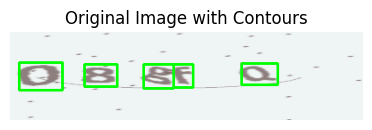

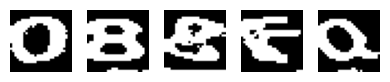

Predicted CAPTCHA: 3a300 | Actual CAPTCHA: 08gfQ


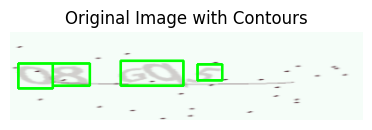

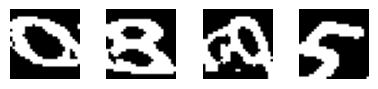

Predicted CAPTCHA: a303 | Actual CAPTCHA: 08Gq5


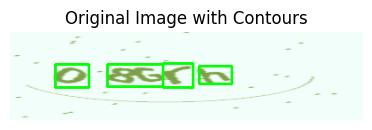

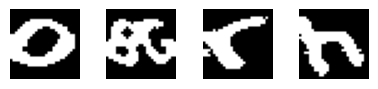

Predicted CAPTCHA: 3333 | Actual CAPTCHA: 08Grh


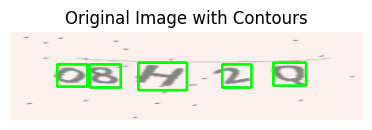

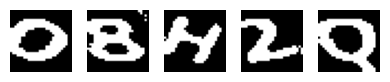

Predicted CAPTCHA: 33a33 | Actual CAPTCHA: 08H2Q


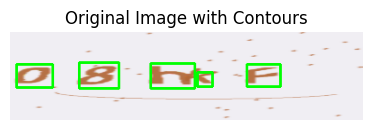

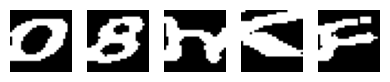

Predicted CAPTCHA: 03333 | Actual CAPTCHA: 08hkF


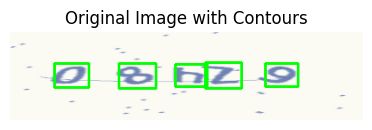

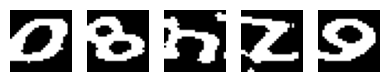

Predicted CAPTCHA: a3330 | Actual CAPTCHA: 08hZ9


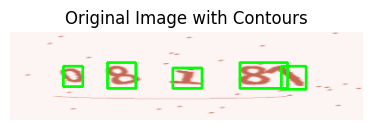

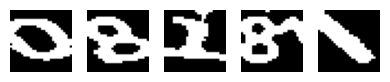

Predicted CAPTCHA: 3a333 | Actual CAPTCHA: 08i81


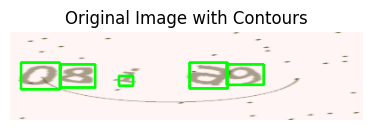

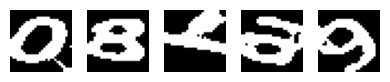

Predicted CAPTCHA: 33338 | Actual CAPTCHA: 08ia9


In [107]:
def process_captcha(image_path, templates):
    image = load_captcha_image(image_path)
    thresh_image = preprocess_image(image)
    contours = find_character_contours(thresh_image)

    visualize_segmentation(image, contours, thresh_image)
    visualize_extracted_characters(image, contours)

    decrypted_captcha = decrypt_captcha(image, contours, templates)
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    print(f"Predicted CAPTCHA: {decrypted_captcha} | Actual CAPTCHA: {image_name}")


input_dir = '../../data/captchas_dataset_1/Large_Captcha_Dataset'
image_files = os.listdir(input_dir)[1830:1838]
directory = "../../data/segmented_images"
templates, alphabet = load_templates_and_alphabet(directory)
print(f"Алфавит: {''.join(alphabet)}")

for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    process_captcha(image_path, templates)
